In [1]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

     |████████████████████████████████| 133kB 5.8MB/s 
     |████████████████████████████████| 92kB 10.6MB/s 
     |████████████████████████████████| 184kB 52.2MB/s 
     |████████████████████████████████| 133kB 55.4MB/s 
     |████████████████████████████████| 890kB 52.1MB/s 
     |████████████████████████████████| 1.2MB 43.9MB/s 
     |████████████████████████████████| 7.2MB 48.1MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=f8383e4e9fe988cf532eb96c97e74e637e3411407b13adbd12155b304f1677ee
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.59 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from pytorch_transformers import DistilBertTokenizer, DistilBertModel, DistilBertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
%cd drive/My Drive/data1

/content/drive/My Drive/data1


In [ ]:
%ls

checkpoint-145/         predictions.json  utils_squad_evaluate.py
checkpoint-150/         __pycache__/      utils_squad.py
nbest_predictions.json  results.json
null_odds.json          train-v2.0.json


In [ ]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
input_file = 'train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [ ]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [ ]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [ ]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
71428,572719a45951b619008f85f7,What is one type of configuration in which a c...,"[Capacitors, may, have, their, connecting, lea...",axially,12,12,False
71429,572719a45951b619008f85f8,What is another type of configuration in which...,"[Capacitors, may, have, their, connecting, lea...",radially,14,14,False
71430,572719a45951b619008f85f9,Which type of configuration is often manufactu...,"[Capacitors, may, have, their, connecting, lea...",Radial,40,40,False
71431,572719a45951b619008f85fa,How are the leads of an axially configured cap...,"[Capacitors, may, have, their, connecting, lea...",on a common axis,21,24,False
71432,572719a45951b619008f85fb,How could radial leads be more correctly descr...,"[Capacitors, may, have, their, connecting, lea...",as tandem,48,49,False
71433,5acf762a77cf76001a684e64,What is one type of configuration in which a c...,"[Capacitors, may, have, their, connecting, lea...",,-1,-1,True
71434,5acf762a77cf76001a684e65,What is another type of configuration in which...,"[Capacitors, may, have, their, connecting, lea...",,-1,-1,True
71435,5acf762a77cf76001a684e66,Which type of configuration is never manufactu...,"[Capacitors, may, have, their, connecting, lea...",,-1,-1,True
71436,5acf762a77cf76001a684e67,How are the leads of an axially configured ca...,"[Capacitors, may, have, their, connecting, lea...",,-1,-1,True
71437,5acf762a77cf76001a684e68,How could radial leads be less correctly desc...,"[Capacitors, may, have, their, connecting, lea...",,-1,-1,True


In [ ]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [ ]:
print_squad_sample(train_data)

CONTEXT: 
There do exist orbits within these empty regions where objects can survive for the
age of the Solar System. These resonances occur when Neptune's orbital period is a
precise fraction of that of the object, such as 1:2, or 3:4. If, say,
an object orbits the Sun once for every two Neptune orbits, it will only
complete half an orbit by the time Neptune returns to its original position. The
most heavily populated resonance in the Kuiper belt, with over 200 known objects, is
the 2:3 resonance. Objects in this resonance complete 2 orbits for every 3 of
Neptune, and are known as plutinos because the largest of the known Kuiper belt
objects, Pluto, is among them. Although Pluto crosses Neptune's orbit regularly, the 2:3 resonance
ensures they can never collide. The 3:4, 3:5, 4:7 and 2:5 resonances are less
populated.
QUESTION:                                                                                            ANSWER:
What is the fraction of the most heavily populated resonance

In [ ]:
train_data['paragraph_len'] = None
train_data['question_len'] = None
for i in range(len(train_data.index)):
  train_data['paragraph_len'][i] = len(train_data['doc_tokens'][i])   ## get the length of 'doc_tokens'  
  train_data['question_len'][i] = len(train_data['question_text'][i])  ## get the length of 'question_text' here  
   #train_data.loc[i,'paragraph_len'] = pd.Series(len(train_data['doc_tokens'][i]), index=train_data.index)
train_data.sample(frac=1).head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
42912,5ad0cde4645df0001a2d0407,What is the acronym for the Organization for t...,"[Eritrea, is, a, member, of, the, United, Nati...",,-1,-1,True,75,81
79721,5727c090ff5b5019007d9468,What is a pipe named at?,"[USB, device, communication, is, based, on, pi...",an endpoint,28,29,False,93,24
28213,56fdc67a19033b140034cd6d,Where was the Roman abacus first used?,"[The, abacus, was, initially, used, for, arith...",Babylonia,14,14,False,66,38
95793,5acd189307355d001abf348b,Who discovered the link between mechanical wor...,"[In, 1807,, Thomas, Young, was, possibly, the,...",,-1,-1,True,102,74
90979,57299ef46aef05140015503d,Lice and bed bugs are considered what kind of ...,"[Many, insects, are, considered, pests, by, hu...",parasitic,16,16,False,89,53


In [ ]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.19289589392184%


In [ ]:
model = 'distilbert-base-uncased' ## choose model https://huggingface.co/models like you can choose basic models such as 'bert-base-uncased' or 'bert-large-uncased' or others

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(model)

100%|██████████| 231508/231508 [00:00<00:00, 5743339.55B/s]


In [ ]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size =  10 # choose 4 - 64

In [ ]:
cached_features_file = 'cache_train'

In [ ]:
type(examples)

list

In [ ]:
example = enumerate(examples)

In [ ]:
type(example)

enumerate

In [ ]:
examples = examples[:1000]## choose first 1000 or 10000 more depending on percentage of train data

In [ ]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  # torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long) ## similarly convert tensor for input mask
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)## similarly convert tensor for segment ids
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)## similarly convert tensor for cls index
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.long)## similarly convert tensor for p mask

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long) ## similarly convert tensor for start position
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)  ## similarly convert tensor for end position
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [ ]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [ ]:
import glob
checkpoints = sorted(glob.glob('checkpoint*-[0-9]*'))

In [ ]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [ ]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = 'checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')  ## choose model https://huggingface.co/models like you can choose basic models such as 'bert-base-uncased' or 'bert-large-uncased' or others

model.cuda()

100%|██████████| 267967963/267967963 [00:03<00:00, 82350478.82B/s]


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (d

In [ ]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[-0.0116, -0.0066,  0.0267,  ...,  0.0147, -0.0089, -0.0401],
        [-0.0216, -0.0395, -0.0038,  ..., -0.0217, -0.0134, -0.0201]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [ ]:
learning_rate = 10000## choose between 1e3 to 1e5
adam_epsilon= 500000000## choose between 1e8 1e9
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [ ]:
num_train_epochs = 2 ## choose 1 to 3 

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)
#'token_type_ids':  batch[2], 
      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 5  == 0: ## choose a number where you want to save
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = 'checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)





Epoch:   0%|          | 0/2 [00:00<?, ?it/s]




Iteration:   0%|          | 0/120 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 1202
  Num Epochs = 2
  Batch size = 10
  Total optimization steps = 60


/usr/local/lib/python3.6/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)





Iteration:   2%|▏         | 2/120 [00:00<00:12,  9.34it/s]




Iteration:   2%|▎         | 3/120 [00:00<00:14,  7.89it/s]




Iteration:   3%|▎         | 4/120 [00:00<00:16,  7.16it/s]




Iteration:   4%|▍         | 5/120 [00:00<00:17,  6.75it/s]

Train loss: nan







Iteration:   5%|▌         | 6/120 [00:02<00:56,  2.01it/s]




Iteration:   6%|▌         | 7/120 [00:02<00:45,  2.49it/s]

Saving model checkpoint to checkpoint-5







Iteration:   7%|▋         | 8/120 [00:02<00:37,  3.00it/s]




Iteration:   8%|▊         | 9/120 [00:02<00:31,  3.51it/s]




Iteration:   8%|▊         | 10/120 [00:02<00:27,  3.99it/s]

Train loss: nan







Iteration:   9%|▉         | 11/120 [00:04<01:00,  1.79it/s]




Iteration:  10%|█         | 12/120 [00:04<00:47,  2.26it/s]

Saving model checkpoint to checkpoint-10







Iteration:  11%|█         | 13/120 [00:04<00:38,  2.76it/s]




Iteration:  12%|█▏        | 14/120 [00:04<00:32,  3.29it/s]




Iteration:  12%|█▎        | 15/120 [00:04<00:27,  3.79it/s]

Train loss: nan







Iteration:  13%|█▎        | 16/120 [00:05<00:57,  1.80it/s]




Iteration:  14%|█▍        | 17/120 [00:06<00:45,  2.26it/s]

Saving model checkpoint to checkpoint-15







Iteration:  15%|█▌        | 18/120 [00:06<00:36,  2.77it/s]




Iteration:  16%|█▌        | 19/120 [00:06<00:30,  3.29it/s]




Iteration:  17%|█▋        | 20/120 [00:06<00:26,  3.80it/s]

Train loss: nan







Iteration:  18%|█▊        | 21/120 [00:07<00:55,  1.79it/s]




Iteration:  18%|█▊        | 22/120 [00:08<00:43,  2.26it/s]

Saving model checkpoint to checkpoint-20







Iteration:  19%|█▉        | 23/120 [00:08<00:35,  2.74it/s]




Iteration:  20%|██        | 24/120 [00:08<00:29,  3.26it/s]




Iteration:  21%|██        | 25/120 [00:08<00:25,  3.71it/s]

Train loss: nan







Iteration:  22%|██▏       | 26/120 [00:10<01:01,  1.52it/s]




Iteration:  22%|██▎       | 27/120 [00:10<00:47,  1.94it/s]

Saving model checkpoint to checkpoint-25







Iteration:  23%|██▎       | 28/120 [00:10<00:38,  2.41it/s]




Iteration:  24%|██▍       | 29/120 [00:10<00:31,  2.89it/s]




Iteration:  25%|██▌       | 30/120 [00:10<00:26,  3.35it/s]

Train loss: nan







Iteration:  26%|██▌       | 31/120 [00:14<02:05,  1.41s/it]

Saving model checkpoint to checkpoint-30







Iteration:  27%|██▋       | 32/120 [00:15<01:32,  1.05s/it]




Iteration:  28%|██▊       | 33/120 [00:15<01:08,  1.26it/s]




Iteration:  28%|██▊       | 34/120 [00:15<00:52,  1.63it/s]




Iteration:  29%|██▉       | 35/120 [00:15<00:41,  2.04it/s]

Train loss: nan







Iteration:  30%|███       | 36/120 [00:21<02:49,  2.02s/it]




Iteration:  31%|███       | 37/120 [00:21<02:02,  1.47s/it]

Saving model checkpoint to checkpoint-35







Iteration:  32%|███▏      | 38/120 [00:21<01:29,  1.09s/it]




Iteration:  32%|███▎      | 39/120 [00:21<01:06,  1.21it/s]




Iteration:  33%|███▎      | 40/120 [00:22<00:50,  1.57it/s]

Train loss: nan







Iteration:  34%|███▍      | 41/120 [00:24<01:23,  1.05s/it]




Iteration:  35%|███▌      | 42/120 [00:24<01:02,  1.25it/s]

Saving model checkpoint to checkpoint-40







Iteration:  36%|███▌      | 43/120 [00:24<00:47,  1.63it/s]




Iteration:  37%|███▋      | 44/120 [00:24<00:36,  2.07it/s]




Iteration:  38%|███▊      | 45/120 [00:24<00:29,  2.55it/s]

Train loss: nan







Iteration:  38%|███▊      | 46/120 [00:34<03:50,  3.11s/it]




Iteration:  39%|███▉      | 47/120 [00:34<02:43,  2.23s/it]

Saving model checkpoint to checkpoint-45







Iteration:  40%|████      | 48/120 [00:34<01:56,  1.62s/it]




Iteration:  41%|████      | 49/120 [00:34<01:24,  1.19s/it]




Iteration:  42%|████▏     | 50/120 [00:35<01:02,  1.13it/s]

Train loss: nan







Iteration:  42%|████▎     | 51/120 [00:40<02:43,  2.37s/it]

Saving model checkpoint to checkpoint-50







Iteration:  43%|████▎     | 52/120 [00:41<01:56,  1.72s/it]




Iteration:  44%|████▍     | 53/120 [00:41<01:24,  1.26s/it]




Iteration:  45%|████▌     | 54/120 [00:41<01:02,  1.06it/s]




Iteration:  46%|████▌     | 55/120 [00:41<00:46,  1.40it/s]

Train loss: nan







Iteration:  47%|████▋     | 56/120 [00:43<01:07,  1.05s/it]




Iteration:  48%|████▊     | 57/120 [00:43<00:49,  1.27it/s]

Saving model checkpoint to checkpoint-55







Iteration:  48%|████▊     | 58/120 [00:43<00:37,  1.64it/s]




Iteration:  49%|████▉     | 59/120 [00:44<00:29,  2.08it/s]




Iteration:  50%|█████     | 60/120 [00:44<00:23,  2.55it/s]

Train loss: nan







Iteration:  51%|█████     | 61/120 [00:49<01:44,  1.77s/it]




Iteration:  52%|█████▏    | 62/120 [00:49<01:14,  1.29s/it]

Saving model checkpoint to checkpoint-60







Iteration:  52%|█████▎    | 63/120 [00:49<00:54,  1.05it/s]




Iteration:  53%|█████▎    | 64/120 [00:49<00:40,  1.39it/s]




Iteration:  54%|█████▍    | 65/120 [00:49<00:30,  1.81it/s]

Train loss: nan







Iteration:  55%|█████▌    | 66/120 [00:56<02:08,  2.38s/it]




Iteration:  56%|█████▌    | 67/120 [00:56<01:30,  1.72s/it]

Saving model checkpoint to checkpoint-65







Iteration:  57%|█████▋    | 68/120 [00:56<01:05,  1.25s/it]




Iteration:  57%|█████▊    | 69/120 [00:56<00:47,  1.08it/s]




Iteration:  58%|█████▊    | 70/120 [00:57<00:34,  1.43it/s]

Train loss: nan







Iteration:  59%|█████▉    | 71/120 [01:05<02:24,  2.94s/it]

Saving model checkpoint to checkpoint-70







Iteration:  60%|██████    | 72/120 [01:05<01:41,  2.12s/it]




Iteration:  61%|██████    | 73/120 [01:05<01:12,  1.54s/it]




Iteration:  62%|██████▏   | 74/120 [01:05<00:51,  1.13s/it]




Iteration:  62%|██████▎   | 75/120 [01:06<00:37,  1.19it/s]

Train loss: nan







Iteration:  63%|██████▎   | 76/120 [01:14<02:22,  3.23s/it]

Saving model checkpoint to checkpoint-75







Iteration:  64%|██████▍   | 77/120 [01:15<01:40,  2.33s/it]




Iteration:  65%|██████▌   | 78/120 [01:15<01:11,  1.69s/it]




Iteration:  66%|██████▌   | 79/120 [01:15<00:50,  1.24s/it]




Iteration:  67%|██████▋   | 80/120 [01:15<00:37,  1.08it/s]

Train loss: nan







Iteration:  68%|██████▊   | 81/120 [01:17<00:49,  1.26s/it]




Iteration:  68%|██████▊   | 82/120 [01:17<00:35,  1.06it/s]

Saving model checkpoint to checkpoint-80







Iteration:  69%|██████▉   | 83/120 [01:18<00:26,  1.39it/s]




Iteration:  70%|███████   | 84/120 [01:18<00:20,  1.79it/s]




Iteration:  71%|███████   | 85/120 [01:18<00:15,  2.23it/s]

Train loss: nan







Iteration:  72%|███████▏  | 86/120 [01:27<01:44,  3.07s/it]




Iteration:  72%|███████▎  | 87/120 [01:27<01:12,  2.20s/it]

Saving model checkpoint to checkpoint-85







Iteration:  73%|███████▎  | 88/120 [01:28<00:51,  1.60s/it]




Iteration:  74%|███████▍  | 89/120 [01:28<00:36,  1.18s/it]




Iteration:  75%|███████▌  | 90/120 [01:28<00:26,  1.13it/s]

Train loss: nan







Iteration:  76%|███████▌  | 91/120 [01:30<00:35,  1.21s/it]




Iteration:  77%|███████▋  | 92/120 [01:30<00:25,  1.10it/s]

Saving model checkpoint to checkpoint-90







Iteration:  78%|███████▊  | 93/120 [01:30<00:18,  1.44it/s]




Iteration:  78%|███████▊  | 94/120 [01:31<00:14,  1.85it/s]




Iteration:  79%|███████▉  | 95/120 [01:31<00:10,  2.28it/s]

Train loss: nan







Iteration:  80%|████████  | 96/120 [01:41<01:21,  3.39s/it]






Saving model checkpoint to checkpoint-95


Iteration:  81%|████████  | 97/120 [01:41<00:55,  2.43s/it]




Iteration:  82%|████████▏ | 98/120 [01:41<00:38,  1.76s/it]




Iteration:  82%|████████▎ | 99/120 [01:42<00:27,  1.29s/it]




Iteration:  83%|████████▎ | 100/120 [01:42<00:19,  1.05it/s]

Train loss: nan







Iteration:  84%|████████▍ | 101/120 [01:44<00:25,  1.36s/it]




Iteration:  85%|████████▌ | 102/120 [01:44<00:18,  1.01s/it]

Saving model checkpoint to checkpoint-100







Iteration:  86%|████████▌ | 103/120 [01:44<00:13,  1.31it/s]




Iteration:  87%|████████▋ | 104/120 [01:45<00:09,  1.66it/s]




Iteration:  88%|████████▊ | 105/120 [01:45<00:07,  2.09it/s]

Train loss: nan







Iteration:  88%|████████▊ | 106/120 [01:55<00:45,  3.27s/it]

Saving model checkpoint to checkpoint-105







Iteration:  89%|████████▉ | 107/120 [01:55<00:30,  2.35s/it]




Iteration:  90%|█████████ | 108/120 [01:55<00:20,  1.70s/it]




Iteration:  91%|█████████ | 109/120 [01:55<00:13,  1.25s/it]




Iteration:  92%|█████████▏| 110/120 [01:55<00:09,  1.07it/s]

Train loss: nan







Iteration:  92%|█████████▎| 111/120 [02:02<00:22,  2.50s/it]




Iteration:  93%|█████████▎| 112/120 [02:02<00:14,  1.80s/it]

Saving model checkpoint to checkpoint-110







Iteration:  94%|█████████▍| 113/120 [02:02<00:09,  1.32s/it]




Iteration:  95%|█████████▌| 114/120 [02:02<00:05,  1.02it/s]




Iteration:  96%|█████████▌| 115/120 [02:02<00:03,  1.35it/s]

Train loss: nan







Iteration:  97%|█████████▋| 116/120 [02:08<00:08,  2.12s/it]




Iteration:  98%|█████████▊| 117/120 [02:08<00:04,  1.54s/it]

Saving model checkpoint to checkpoint-115







Iteration:  98%|█████████▊| 118/120 [02:08<00:02,  1.13s/it]




Iteration:  99%|█████████▉| 119/120 [02:08<00:00,  1.18it/s]




Iteration: 100%|██████████| 120/120 [02:08<00:00,  1.07s/it]




Epoch:  50%|█████     | 1/2 [02:08<02:08, 128.87s/it]




Epoch: 100%|██████████| 2/2 [02:08<00:00, 64.47s/it] 


In [ ]:
output_dir = 'checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [ ]:
train_loss_set_ckpt = torch.load('checkpoint-115/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

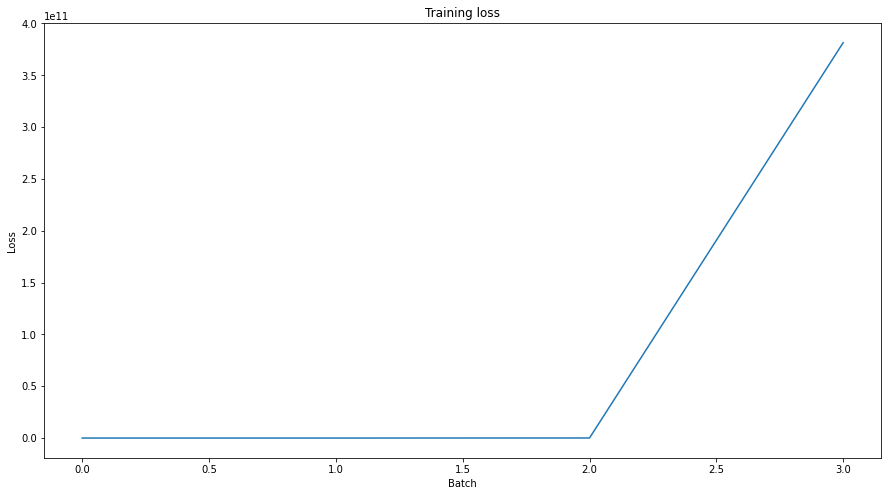

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
input_file = 'dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = 'cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
# Convert to Tensors and build dataset
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long) ## similarly convert tensor for input mask
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)## similarly convert tensor for segment ids
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)## similarly convert tensor for cls index
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.long)## similarly convert tensor for p mask

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [ ]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

In [ ]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = 'dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                #'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "predictions.json"
  output_nbest_file = "nbest_predictions.json"
  output_null_log_odds_file = "null_odds.json"
  output_dir = "predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [ ]:
results = evaluate(model, tokenizer)





Evaluating:   0%|          | 0/1360 [00:00<?, ?it/s]

***** Running evaluation *****
  Num examples = 13600
  Batch size = 10






Evaluating:   7%|▋         | 100/1360 [00:05<01:05, 19.12it/s]



Evaluating:  15%|█▍        | 200/1360 [00:10<01:00, 19.13it/s]



Evaluating:  22%|██▏       | 300/1360 [00:15<00:55, 19.15it/s]



Evaluating:  29%|██▉       | 400/1360 [00:20<00:50, 19.18it/s]



Evaluating:  37%|███▋      | 500/1360 [00:26<00:44, 19.18it/s]



Evaluating:  44%|████▍     | 600/1360 [00:31<00:39, 19.20it/s]



Evaluating:  51%|█████▏    | 700/1360 [00:36<00:34, 19.20it/s]



Evaluating:  59%|█████▉    | 800/1360 [00:41<00:29, 19.19it/s]



Evaluating:  66%|██████▌   | 900/1360 [00:46<00:23, 19.21it/s]



Evaluating:  74%|███████▎  | 1000/1360 [00:52<00:18, 19.20it/s]



Evaluating:  81%|████████  | 1100/1360 [00:57<00:13, 19.21it/s]



Evaluating:  88%|████████▊ | 1200/1360 [01:02<00:08, 19.22it/s]



Evaluating: 100%|██████████| 1360/1360 [01:10<00:00, 19.20it/s]


{
  "exact": 47.39324517813527,
  "f1": 47.450638379003436,
  "total": 11873,
  "HasAns_exact": 0.0,
  "HasAns_f1": 0.11495099087512396,
  "HasAns_total": 5928,
  "NoAns_exact": 94.65096719932717,
  "NoAns_f1": 94.65096719932717,
  "NoAns_total": 5945,
  "best_exact": 50.07159100480081,
  "best_exact_thresh": 0.0,
  "best_f1": 50.07159100480081,
  "best_f1_thresh": 0.0
}


In [ ]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 47.39324517813527}, {'f1': 47.450638379003436}, {'total': 11873}, {'HasAns_exact': 0.0}, {'HasAns_f1': 0.11495099087512396}, {'HasAns_total': 5928}, {'NoAns_exact': 94.65096719932717}, {'NoAns_f1': 94.65096719932717}, {'NoAns_total': 5945}, {'best_exact': 50.07159100480081}, {'best_exact_thresh': 0.0}, {'best_f1': 50.07159100480081}, {'best_f1_thresh': 0.0}]
